# Processamento de Streams 2023
## TP1 - Air Quality Monitoring (airborne particulate matter)


The goal of this project is to analyze data provided by a set of air quality sensors. The sensors present in the dataset are located in Portugal. Each sensor provides two values: measuring particles less than 10 µm (P1) in μg/m³.

The sensor data, covers the month of March 2022, and is streamed of Kafka.

Each data sample has the following schema:

timestamp | sensor_id | sensor_type | location | latitude | longitude | P1
----------|-------------|----------|----------|-----------|-----------|----
timestamp | string  | string | string | float | float|  float



## Question

2. Compute the minumum, average and maximum of P1 (particles smaller than 10 µm) values, for the last two hours, updated every 10 minutes.


## Requeriments

Solve each question using either Unstructed Spark Streaming or Structured Spark Streaming.

To achieve the maximum grade, you need to use both, but do not have to solve every question twice.

## Other Grading Criteria

+ 10% of the grade is reserved for presenting the results graphically as charts;
+ Grading will also take into account the general clarity of the programming and of the presentation report (notebook).




### Deadline

29th April + 1 day - ***no penalty***

For each day late, ***0.5 / day penalty***. Penalty accumulates until
the grade of the assignment reaches 8.0.

---
### Colab Setup


In [1]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


'/usr/local/lib/python3.10/dist-packages/pyspark'

In [3]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.4.1
KAFKA=kafka_2.12-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2023/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties

Formatting /tmp/kraft-combined-logs with metadata.version 3.4-IV0.


### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [4]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2023/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null
wget -q -O sensors-sorted.csv https://github.com/smduarte/ps2023/raw/main/tp1/sensors-sorted.csv

nohup python kafka-tp1-logsender/publisher.py --filename sensors-sorted.csv --topic air_quality  --speedup 60 2> kafka-publisher-error.log > kafka-publisher-out.log &

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
#@title Python Kafka client (For Debugging)
!pip -q install confluent-kafka
from confluent_kafka import Consumer

conf = {'bootstrap.servers': 'localhost:9092',
        'group.id': '*',
        'enable.auto.commit': False,
        'auto.offset.reset': 'earliest'}

try:
  consumer = Consumer(conf)
  consumer.subscribe(['air_quality'])

  while True:
    msg = consumer.poll(timeout=1.0)
    if msg is None: continue
    print(msg.value())
finally:
  consumer.close()

The python code below shows the basics needed to process JSON data from Kafka source using PySpark.

Spark Streaming python documentation is found [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.streaming.html)

---
#### PySpark Kafka Stream Example


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df.show(200, False)

spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

query = lines \
    .writeStream \
    .format('csv') \
    .option('path','dir') \
    .outputMode('append') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(60)
query.stop()
spark.stop()

+--------------------+--------------------+----+------+------------------+
|               start|                 end| min|   max|               avg|
+--------------------+--------------------+----+------+------------------+
|2022-03-01T05:20:...|2022-03-01T07:20:...|3.19|185.23|27.635807236656547|
|2022-03-01T05:30:...|2022-03-01T07:30:...|3.19|219.43|28.966736252563116|
|2022-03-01T04:40:...|2022-03-01T06:40:...|3.55|185.23|24.026710129282183|
|2022-03-01T04:50:...|2022-03-01T06:50:...|3.55|185.23|25.247722490919823|
|2022-02-28T22:30:...|2022-03-01T00:30:...|5.07|105.63|21.061489384225073|
|2022-02-28T22:40:...|2022-03-01T00:40:...| 4.1|105.63|20.582440954493727|
|2022-02-28T22:10:...|2022-03-01T00:10:...|6.88|105.63|23.250322572646603|
|2022-02-28T22:20:...|2022-03-01T00:20:...|5.07|105.63| 21.86301594688779|
|2022-03-01T11:50:...|2022-03-01T13:50:...|0.64| 34.17|14.247999955040134|
|2022-03-01T12:00:...|2022-03-01T14:00:...|0.64| 34.17|13.976565892388532|
|2022-03-01T12:10:...|202

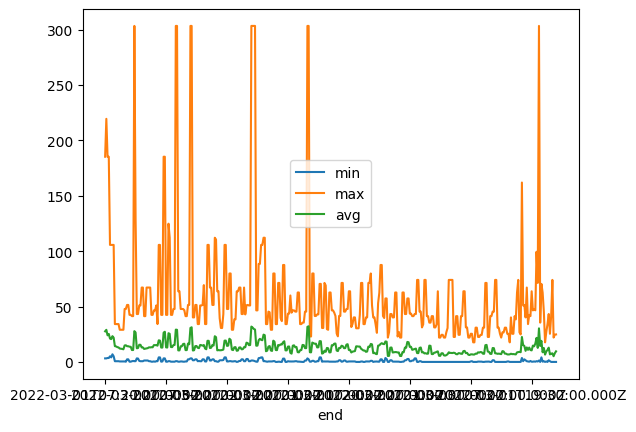

In [5]:
#@title 2nd point Structured Spark Streaming
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


def dumpBatchDF(df, epoch_id):
    structured_df = df.selectExpr(
        "window.start",
        "window.end",
        "min",
        "max",
        "avg"
    )
    #df.show(40,truncate=False)
    #print(df1.schema)
    structured_df.write.json("th_data", mode="overwrite")

spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*') \
            .withWatermark('timestamp', '3 hours') \
            .dropDuplicates() \
            .groupBy(window('timestamp', '2 hours', '10 minutes')) \
            .agg(min('p1').alias('min'), max('p1').alias('max'), mean('p1').alias('avg')) \
            .orderBy('window')

query = lines \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(3600)
query.stop()
schema_csv = StructType([
                StructField('start', StringType(), True),
                StructField('end', StringType(), True),
                StructField('min', FloatType(), True),
                StructField('max', FloatType(), True),
                StructField('avg', DoubleType(), True)])
complete_dataframe = spark.read.schema(schema_csv).format("json").load("th_data")
complete_dataframe.show(20)
complete_dataframe.toPandas().plot.line(x='end', y=['min', 'max', 'avg'])

spark.stop()

### Spark Streaming (UnStructured)

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

In [ ]:
#@title Start Socket-based Publisher
%%bash
pip install kafka-python dataclasses --quiet

wget -q -O - https://github.com/smduarte/ps2023/raw/main/colab/socket-tp1-logsender.tgz | tar xfz - 2> /dev/null
wget -q -O sensors-sorted.csv https://github.com/smduarte/ps2023/raw/main/tp1/sensors-sorted.csv

nohup python socket-tp1-logsender/publisher.py --filename sensors-sorted.csv --speedup 60 2> socket-publisher-error.log > socket-publisher-out.log &

Each line sample has the following parts separated by blanks:

| timestamp| sensor_id | sensor_type | location | latitude | longitude | P1
----------|-------------|----------|----------|-----------|-----------|----
timestamp| string  | string | string | float | float| float |



In [ ]:
#@title Spark Streaming (Unstructured) Example
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession \
    .builder \
    .appName('Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777)

  lines.pprint()

  ssc.start()
  ssc.awaitTermination(20)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()